#### Paso 1. Lectura del conjunto de datos

In [3]:
import pandas as pd

total_data = pd.read_csv("/Users/julian/Desktop/vs code/Spam_link_detection_system_Project_22_Julian_Lopez/Spam_link_detection_system_Project_22_Julian_Lopez/data/raw/url_spam.csv")
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
print(type(total_data["is_spam"].iloc[0]))  # Verificar el tipo de datos de un valor de la columna


<class 'numpy.bool'>


#### Paso 2: Procesamiento de datos

##### Transformación categórica a numérica

In [5]:
total_data["is_spam"] = total_data["is_spam"].astype(int)
total_data.head()


,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


##### Eliminación de valores repetidos

In [6]:
print(total_data.shape)
print(f"Spam: {len(total_data.loc[total_data['is_spam'] == 1])}")
print(f"No spam: {len(total_data.loc[total_data['is_spam'] == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


In [7]:
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace = False, drop = True)
total_data.shape

(2369, 2)

##### Procesamiento del texto

In [8]:
import re

def preprocess_text(text):
    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)

    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

total_data["url"] = total_data["url"].apply(preprocess_text)
total_data.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


#### Lematización del texto

In [15]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS  # Usamos las stopwords de sklearn
nltk.download('wordnet')
# Lematizador
lemmatizer = WordNetLemmatizer()

def lemmatize_text(words, lemmatizer=lemmatizer):
    # Lematizar cada palabra
    tokens = [lemmatizer.lemmatize(word) for word in words]
    
    # Filtrar stopwords usando las stopwords de sklearn
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    
    # Filtrar palabras muy cortas (menos de 3 caracteres)
    tokens = [word for word in tokens if len(word) > 3]
    
    return tokens

# Aplicar la lematización en la columna "url" de tu DataFrame
total_data["url"] = total_data["url"].apply(lemmatize_text)

# Ver el resultado
total_data.head()


[nltk_data] Downloading package wordnet to /Users/julian/nltk_data...


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


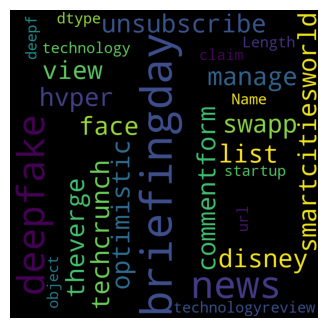

In [23]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 77)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens_list = total_data["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [37]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [38]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [39]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9514767932489452

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Definir los posibles valores de los hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}

# Crear el modelo
model = SVC(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores Hiperparámetros: ", grid_search.best_params_)


Mejores Hiperparámetros:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [35]:
# Obtener el mejor modelo después de GridSearchCV
best_model = grid_search.best_estimator_

# Realizar las predicciones
y_pred = best_model.predict(X_test)

# Mostrar las predicciones
print("Predicciones: ", y_pred)


Predicciones:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


In [40]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9514767932489452